### Change Log for Support-Vector-Machines 

This notebook includes code from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) written by Jake VanderPlas. 
- The original notebook explains Support Vector Machines (SVMs) using visuals, especially when dealing with well-separated classes. It emphasizes the importance of maximizing the margin between the decision boundary and support vectors.

In my notebook, I take a similar approach, but I apply SVMs to recognize butterflies using a labeled dataset of butterflies. 
- This demonstrates how SVMs can be versatile in different applications, making them effective for various classification tasks.

#### [1. Understanding the Algorithm](#algorithm-understanding)
- **Objective:**
- 

- **Changes:**
- 


### Butterfly Species Image Classification

#### [2. Data Understanding](#data-understanding)
- **Dataset Description:**
  - Utilized a dataset consisting of 75 different classes of butterflies:
  - Over 9000 labeled images
  - Data set includes including validation images.

CSV Files:
 - Testing_set.csv: 2786 unique jpgs
 - Training_set.csv: 6499 unique labeled images
 
Directories:
- test: Contains images from Testing_set.csv
- train: Contains labeled images from Training_set.csv

- **Changes:**
  - The model is now using a dataset of `75 butterfly types` instead of `labled faces`


#### [3. Data Preparation](#data-preparation)
**Data Cleaning:**
- The dataset does not contain any null values, because of the type of data, we will not be checking for duplicates. 
  
- **Changes:**
  - Due to the large number of detailed images:
  - Images resized to 100x100 for efficiency and standardization.
  - Flattened into 1D arrays to simplify input format & increase training speed.

#### [4. Modeling](#modeling)
**Implementation Details:**
1. RBF Kernel SVM: Applied for its flexibility in capturing non-linear relationships between data points.

**Changes:**

2. Linear Kernel SVM: Selected for its effectiveness in linearly separable datasets.



#### [5. Evaluation](#evaluation)
- **Challenges Encountered:**
  - Evaluated the models' performance using accuracy scores and confusion matrices.

- **Changes:**
  - Detailed the challenges faced during model evaluation for butterfly species classification.

#### [6. Deployment](#deployment)

- **Challenges Encountered:**
  - Discussed potential challenges and considerations for deploying the SVM models in a real-world scenario.


In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from skimage import io, transform 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

#### 1. Understanding the Algorithm <a id='algorithm-understanding'></a>

### Example: Butterfly Species Classification

To demonstrate support vector machines in action, I will do similar classification technique using butterflys instead of faces

#### 2. Data Understanding <a id='data-understanding'></a>

The data set is taken from Kagggle and features 75 different classes of Butterflies. The dataset contains 9000+ labelled images including the validation images.

CSV Files:
 - Testing_set.csv: 2786 unique jpgs
 - Training_set.csv: 6499 unique labeled images
 
Directories:
- test: Contains images from Testing_set.csv
- train: Contains labeled images from Training_set.csv

In [2]:
# Load the training and testing datasets
trainingData = pd.read_csv('archive-2/Training_set.csv')
testingData = pd.read_csv('archive-2/Testing_set.csv')

# Path to the folder containing the training images
train_folder_path = 'archive-2/train'
test_folder_path = 'archive-2/test'

# Initialize lists to store image paths and labels
train_image_paths = []
test_image_paths = []
labels = []

# Loop through the training dataset and collect image paths and labels
for i in range(len(trainingData)):
    filename = trainingData['filename'].iloc[i]
    label = trainingData['label'].iloc[i]
    train_image_paths.append(os.path.join(train_folder_path, filename))
    labels.append(label)

Let's print a few butterflies to see what we're working with:

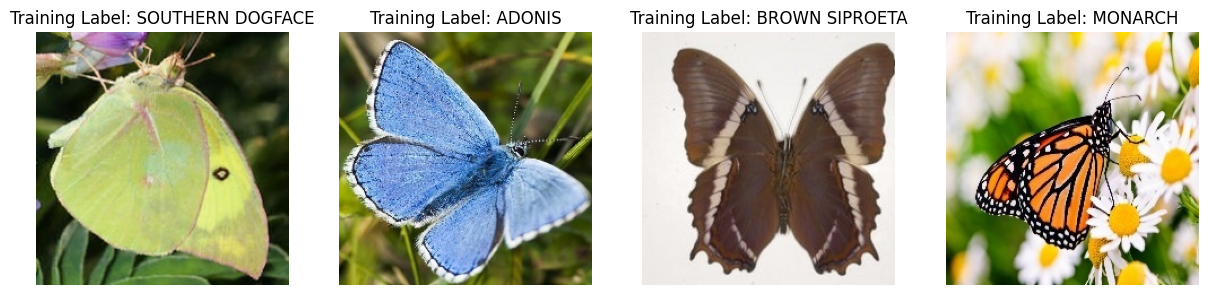

In [3]:
import matplotlib.pyplot as plt

# Display the first 4 butterflies
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, (train_image_path, label) in enumerate(zip(train_image_paths[:4], labels[:4])):
    image = io.imread(train_image_path)
    axs[i].imshow(image)
    axs[i].set_title(f'Training Label: {label}')
    axs[i].axis('off')

plt.show()

#### 3. Data Preparation <a id='data-preparation'></a>

As can be seen from the output the resized images are smaller & reduced to 100x100 pixels. The images have lost some definition and clarity but still are recognisable. 

These images had to be flattened and resized into a 1D array due to the amount of images increasing computational complexity for the model. 

In [4]:
# Resize images & flatten into array 
#images = [transform.resize(io.imread(path), (100, 100)).flatten() for path in train_image_paths]
# Warning: 1m runtime 

In [5]:
#Attempt to paralise to sepped up flattening 
from joblib import Parallel, delayed

def process_image(path):
    return transform.resize(io.imread(path), (100, 100)).flatten()

images = Parallel(n_jobs=-1)(delayed(process_image)(path) for path in train_image_paths)
# Takes 20.8sec

In [6]:
# Resize test images & flatten
#test_images = [transform.resize(io.imread(path), (100, 100)).flatten() for path in test_image_paths]

In [7]:
# Load all images from the testing dataset
for i in range(len(testingData)):
    filename = testingData['filename'].iloc[i]
    test_image_paths.append(os.path.join(test_folder_path, filename))


#Attempt to paralise to sepped up flattening 
def process_image(path):
    return transform.resize(io.imread(path), (100, 100)).flatten()

test_images = Parallel(n_jobs=-1)(delayed(process_image)(path) for path in test_image_paths)


#### 4. Modeling <a id='modeling'></a>

In this notebook I execute two types of model:
1. RBF Model:
2. Linear Modeling: 

##### RBF SVM Model (same method as VanderPlas)

In [8]:
X_train = np.array(images)
y_train = labels

# Create the PCA, SVC, and pipeline
pca = PCA(n_components=50, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [9]:
# Define the hyperparameter grid
param_grid = {'svc__C': [1, 5, 10],
            'svc__gamma': [0.0001, 0.001, 0.01]}  # Reduced search space for faster execution
grid = GridSearchCV(model, param_grid)

In [10]:
# Fit the model using training data with labels
%time grid.fit(X_train, y_train)
print(grid.best_params_)
#12 min

CPU times: user 30min 58s, sys: 7min 51s, total: 38min 49s
Wall time: 18min 1s
{'svc__C': 10, 'svc__gamma': 0.01}


In [11]:
X_test_array = np.array(test_images)

model = grid.best_estimator_
yfit = model.predict(X_test_array)

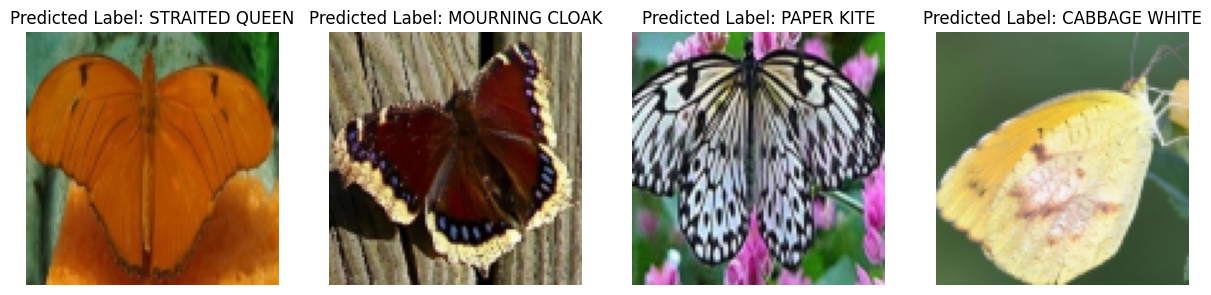

In [12]:
# Select a random sample of images from the test set
random_indices = random.sample(range(len(X_test_array)), 4)

# Display test images and their predicted labels
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, index in enumerate(random_indices):
    test_image = X_test_array[index].reshape((100, 100, 3))  # Assuming the original shape is (100, 100, 3)
    predicted_label = yfit[index]
    
    axs[i].imshow(test_image)
    axs[i].set_title(f'Predicted Label: {predicted_label}')
    axs[i].axis('off')

plt.show()

##### Linear SVM Model

Using the same `X_train` & `y_train` values as the previous model

In [13]:
#Initialize and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
#careful this takes 7,36.4min to run

SVC(kernel='linear')

In [14]:
# Make predictions on the validation set
y_pred_test = svm_model.predict(test_images)
# Warning: this takes 4 min 50s  to run

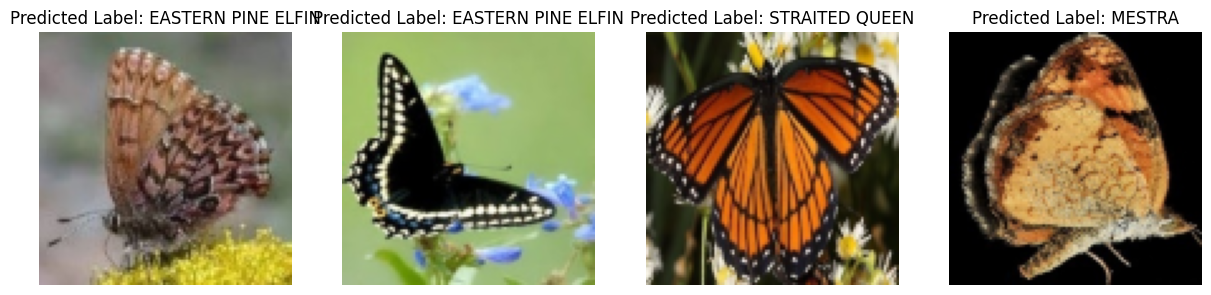

In [15]:
# Select a random sample of images from the test set
random_indices = random.sample(range(len(X_test_array)), 4)

# Display test images and their predicted labels
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for i, index in enumerate(random_indices):
    test_image = X_test_array[index].reshape((100, 100, 3)) 
    predicted_label = y_pred_test[index]
    
    axs[i].imshow(test_image)
    axs[i].set_title(f'Predicted Label: {predicted_label}')
    axs[i].axis('off')


#### 5. Evaluation <a id='evaluation'></a>

#### 6. Deployment <a id='deployment'></a>